In [2]:
import sys
sys.path.insert(0, "../..")

import jax
import jax.numpy as jnp

import jax.scipy
import jax.scipy.special

from tqdm import tqdm
from functools import partial

import module.samplers
import module.hamiltonians
import module.wavefunctions
import module.misc.cutoffs as cutoffs

import flax.linen as nn

import optax
import numpy as np
from matplotlib import pyplot as plt

import netket.nn.activation
import pickle

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
key = jax.random.PRNGKey(0)

In [4]:
def getLine(phi, theta, r_max = 10, N = 2000):
    r = jnp.linspace(-r_max, r_max, num = N)
    x = jnp.cos(phi)*jnp.sin(theta) * r
    y = jnp.sin(phi)*jnp.sin(theta) * r
    z = jnp.cos(theta) * r

    return r, jnp.stack((x,y,z), axis = 1)

## Potential Energy

In [11]:
#
# The potential energy function depending on the coordinates
#
def potential(x, params):
    d = jnp.sqrt(jnp.sum((x)**2, axis = 1))
    return -1/d


# the hamiltonian
hamiltonian = module.hamiltonians.Particles(masses = [1], potential = potential)


## Construct Neural Network

In [43]:
def act(x):
    return nn.softplus(x)

In [82]:
class NN(nn.Module):
    """
    Constructs a neural network.

    possible activation functions:
    netket.nn.activation.log_cosh(x)
    nn.softplus()
    """
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(40, name="dense2", param_dtype="float64", bias_init=jax.random.normal)(x)
        x = act(x)
        x = nn.Dense(40, name="dense3", param_dtype="float64", bias_init=jax.random.normal)(x)
        x = act(x)
        x = nn.Dense(25, name="dense4", param_dtype="float64", bias_init=jax.random.normal)(x)
        x = act(x)
        x = nn.Dense(1, name="dense5", param_dtype="float64", bias_init=jax.random.normal)(x)
        # x = act(x)
        return jnp.squeeze(x)

## Single Nucleus

In [83]:
orbital = module.wavefunctions.Orbital(1, jnp.array([0.,0.,0.]))
orbital_param = 1.

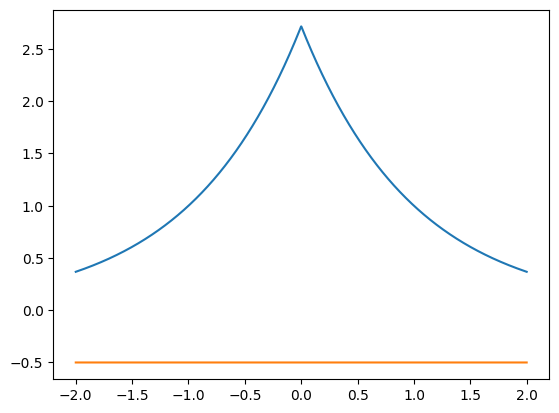

In [84]:
r, line = getLine(0, jnp.pi/2, r_max=2)
psi_lcao = orbital.calc_psi(orbital_param, line)

H_loc = hamiltonian.calc_H_loc(orbital, orbital_param, line)

plt.plot(r, psi_lcao)
plt.plot(r, H_loc)

## Construct Ansatz

In [85]:
class Ansatz(module.wavefunctions.Wavefunction):
    def __init__(self):
        super().__init__(input_shape = (3,))
        self.nn = NN()


    def init_param(self, key):
        nn_param = self.nn.init(key, jnp.empty((3,)))

        return nn_param
    
    def eval_nn(self, parameters, x):
        return self.nn.apply(parameters, x) - self.nn.apply(parameters, jnp.array([0.,0.,0.]))
    
    def calc_logpsi(self, parameters, x):
        return jnp.log(orbital.calc_psi(orbital_param, x) + self.eval_nn(parameters, x)*(1.+0.0j))

In [100]:
ansatz = Ansatz()
key, _ = jax.random.split(key)
param = ansatz.init_param(key)

/home/ewonisch/NeuralQuantumStates/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


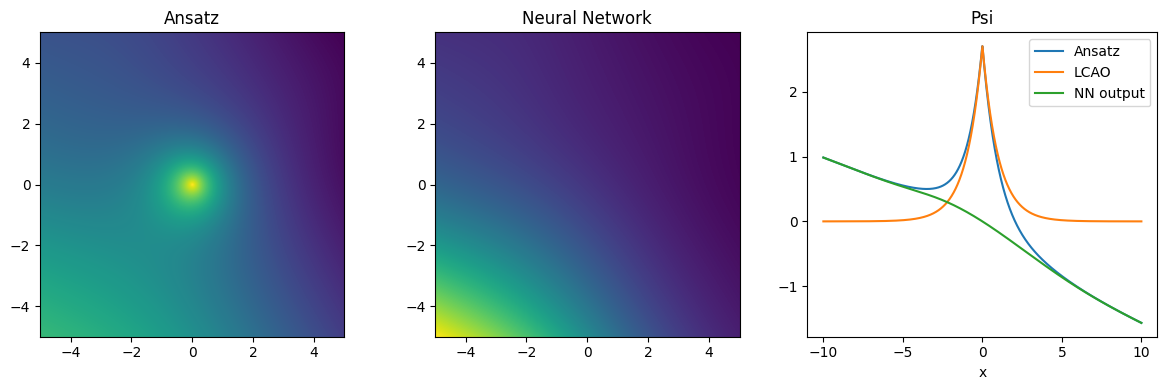

In [101]:
f, axs = plt.subplots(1, 3, figsize = (12,4))

xs = jnp.linspace(-5, 5, num = 1000)
ys = jnp.linspace(-5, 5, num = 1000)
xss, yss = jnp.meshgrid(xs, ys)
im = jnp.stack((xss, yss, jnp.ones_like(xss) * 0), axis = 2)

res = ansatz.calc_psi(param, im.reshape(-1, 3)).reshape(xss.shape)
res = res.real


axs[0].imshow(res, extent = [-5, 5, -5, 5])
axs[0].set_title("Ansatz")

res = ansatz.eval_nn(param, im.reshape(-1, 3)).reshape(xss.shape)
axs[1].imshow(jnp.exp(res), extent = [-5, 5, -5, 5])
axs[1].set_title("Neural Network")


r, line = getLine(0, jnp.pi/2, r_max=10)
psi = ansatz.calc_psi(param, line)
psi_lcao = orbital.calc_psi(orbital_param, line)
nn_out = ansatz.eval_nn(param, line)

axs[2].plot(r, psi, label = "Ansatz")
axs[2].plot(r, psi_lcao, label = "LCAO")
axs[2].plot(r, nn_out, label = "NN output")

axs[2].set_title("Psi")
axs[2].legend()
axs[2].set_xlabel("x")

f.tight_layout()

## Energy Inspection

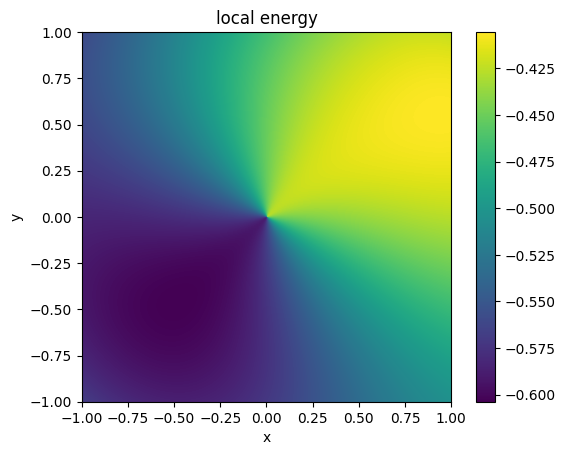

In [110]:
l = 1
xs = jnp.linspace(-l, l, num = 1000)
ys = jnp.linspace(-l, l, num = 1000)
xss, yss = jnp.meshgrid(xs, ys)
im = jnp.stack((xss, yss, jnp.ones_like(xss) * 0), axis = 2)

res = hamiltonian.calc_H_loc(ansatz, param, im.reshape(-1, 3)).reshape(xss.shape)

plt.imshow(res.real, extent=[-l,l,-l,l])
plt.xlabel("x")
plt.ylabel("y")
plt.title("local energy")
plt.colorbar()

/home/ewonisch/NeuralQuantumStates/.venv/lib/python3.10/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0.5, 0, 'x')

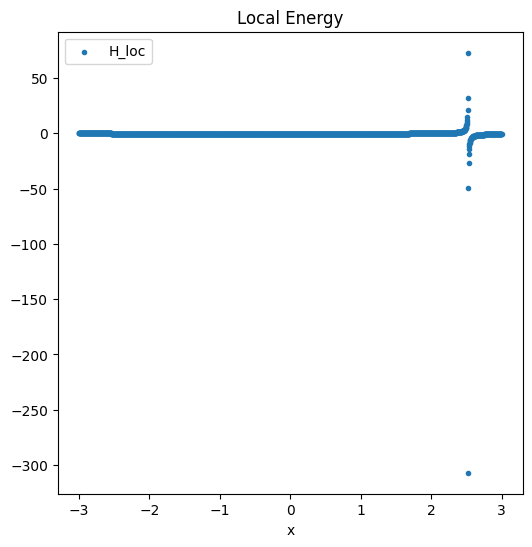

In [97]:
plt.figure(figsize=(6, 6))

r, line = getLine(0, jnp.pi/2, r_max=3)
psi = ansatz.calc_psi(param, line)
psi_lcao = orbital.calc_psi(orbital_param, line)
nn_out = ansatz.eval_nn(param, line)

H_loc = hamiltonian.calc_H_loc(ansatz, param, line)

# plt.plot(r, T_loc, label = "T_loc")
# plt.plot(r, -V_loc, label = "V_loc")
plt.scatter(r, H_loc, label = "H_loc", marker = ".")
# plt.yscale("log")
# plt.ylim(-5,5)

plt.title("Local Energy")
plt.legend()
plt.xlabel("x")